### PROBLEM STATEMENT

The objective of this project is to predict future market regime shifts (e.g., upward, downward using a Directional Change (DC) framework, where the target variable is defined as:

1. 1 (Buy): Predicted upward regime.

2. 0 (Sell): Predicted downward regime.


### Key Adjustments for DC Framework; Event Definition:

1. DC Upward Event: Short-term price movement ≥ threshold (e.g., Δ% from trough to peak).

2. DC Downward Event: Short-term price movement ≤ threshold (e.g., Δ% from peak to trough).

### INSTALL LIBRARIES

In [ ]:
!pip install ta

In [ ]:
!pip install quantreo

### LOADING THE REQUIRED PYTHON PACKAGES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
import seaborn as sns
sns.set_style("whitegrid")
import quantreo.features_engineering as fe
from Directional_change import *
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.mosaicplot import mosaic

In [ ]:
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import KernelPCA

### LOAD DATA

In [ ]:

#data.reset_index(drop=True, inplace=True)

eur_usd = pd.read_csv('4-hours_EURUSD.csv')
gbp_usd = pd.read_csv('4-hours_GBPUSD.csv')
usd_cad = pd.read_csv('4-hours_USDCAD.csv')
usd_chf = pd.read_csv('4-hours_USDCHF.csv')
usd_jpy = pd.read_csv('4-hours_USDJPY.csv')
eur_usd.columns

Index(['time', 'open', 'high', 'low', 'close', 'tick_volume', 'low_time',
       'high_time'],
      dtype='object')

In [ ]:
eur_usd.head()

time     open     high      low    close  tick_volume  \
0  2015-01-02 12:00:00  1.20467  1.20600  1.20347  1.20377        14827   
1  2015-01-02 16:00:00  1.20377  1.20437  1.20069  1.20131        19160   
2  2015-01-02 20:00:00  1.20133  1.20154  1.20011  1.20029         9335   
3  2015-01-03 00:00:00  1.20030  1.20055  1.19997  1.20014         1351   
4  2015-01-05 00:00:00  1.19454  1.19755  1.18642  1.19624        13941   

              low_time            high_time  
0  2015-01-02 15:36:00  2015-01-02 12:48:00  
1  2015-01-02 19:36:00  2015-01-02 16:00:00  
2  2015-01-02 23:12:00  2015-01-02 20:00:00  
3  2015-01-03 00:24:00  2015-01-03 00:00:00  
4  2015-01-05 00:48:00  2015-01-05 03:36:00

### TARGET & FEATURE ENGINEERING FUNCTIONS

In [ ]:
def target_engineering(df, n=0.03):
    df = df.reset_index(drop=True)
    df = future_DC_market_regime(df, n)
    return df


In [ ]:
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))
    return ROC


#calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM


def STOK(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) /(high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK

def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD

In [ ]:
def feature_engineering(df):
    df_copy = df.copy()
    df_copy['candle_way'], df_copy['filling'], df_copy['amplitude'] = fe.candle.candle_information(df_copy)
    df_copy['amplitude'] = df_copy['amplitude'] * 100
    df_copy['spread'] = fe.candle.compute_spread(df_copy)
    df_copy['ROC10'] = ROC(df_copy['close'], 10)
    df_copy['ROC30'] = ROC(df_copy['close'], 30)
    df_copy['MOM10'] = MOM(df_copy['close'], 10)
    df_copy['MOM30'] = MOM(df_copy['close'], 30)
    df_copy['%K10'] = STOK(df_copy['close'],df_copy['low'], df_copy['high'], 10)
    df_copy['%D10'] = STOD(df_copy['close'],df_copy['low'], df_copy['high'], 10)
    df_copy['%K30'] = STOK(df_copy['close'],df_copy['low'], df_copy['high'], 30)
    df_copy['%D30'] = STOD(df_copy['close'],df_copy['low'], df_copy['high'], 30)
    df_copy['%K200'] = STOK(df_copy['close'],df_copy['low'], df_copy['high'], 200)
    df_copy['%D200'] = STOD(df_copy['close'],df_copy['low'], df_copy['high'], 200)
    df_copy['RSI_14'] = ta.momentum.rsi(df_copy['close'], window=14)
    df_copy['RSI_30'] = ta.momentum.rsi(df_copy['close'], window=30)
    df_copy['RSI_100'] = ta.momentum.rsi(df_copy['close'], window=100)
    df_copy['RSI_200'] = ta.momentum.rsi(df_copy['close'], window=200)
    df_copy['hurst_stats'] = fe.math.hurst(df_copy,'close')
    df_copy['kama_market_regime_indicator'] = fe.market_regime.kama_market_regime(df_copy,'close')
    #df_copy['velocity'], df_copy['acceleration'] = fe.math.derivatives(df_copy, 'close')
    for num in [2, 5, 10, 20, 40, 60, 80, 100, 150]:
        df_copy[f'log_{num}_return'] = fe.math.log_pct(df_copy,col='close', window_size= num)
        if num > 50:
            df_copy[f'auto_corr_{num}']  = fe.math.auto_corr(df_copy,col='close',window_size=200, lag = num)
    df_copy["log_close"] = np.log(df_copy['close'])
    df_copy['kama_(moving_average)'] = fe.trend.kama(df_copy, col='close')
    # Standard volatility
    df_copy["vol_close_to_close_30"] = fe.volatility.close_to_close_volatility(df_copy, window_size=30)
    df_copy["vol_close_to_close_60"] = fe.volatility.close_to_close_volatility(df_copy, window_size=60)
    df_copy["vol_close_to_close_90"] = fe.volatility.close_to_close_volatility(df_copy, window_size=90)

    # Parkinson volatility
    df_copy["vol_parkinson_30"] = fe.volatility.parkinson_volatility(df_copy, window_size=30)
    df_copy["vol_parkinson_60"] = fe.volatility.parkinson_volatility(df_copy, window_size=60)
    df_copy["vol_parkinson_90"] = fe.volatility.parkinson_volatility(df_copy, window_size=90)

    # Rogers-Satchell volatility
    df_copy["vol_rogers_satchell_30"] = fe.volatility.rogers_satchell_volatility(df_copy, window_size=30)
    df_copy["vol_rogers_satchell_60"] = fe.volatility.rogers_satchell_volatility(df_copy, window_size=60)
    df_copy["vol_rogers_satchell_90"] = fe.volatility.rogers_satchell_volatility(df_copy, window_size=90)

    # Yang-Zhang volatility
    df_copy["vol_yang_zhang_30"] = fe.volatility.yang_zhang_volatility(df_copy, window_size=30)
    df_copy["vol_yang_zhang_60"] = fe.volatility.yang_zhang_volatility(df_copy, window_size=60)
    df_copy["vol_yang_zhang_90"] = fe.volatility.yang_zhang_volatility(df_copy, window_size=90)


    return df_copy




# EXPLORATORY DATA ANALYSIS

### VISUAL REPRESENTATION OF MARKET REGIME

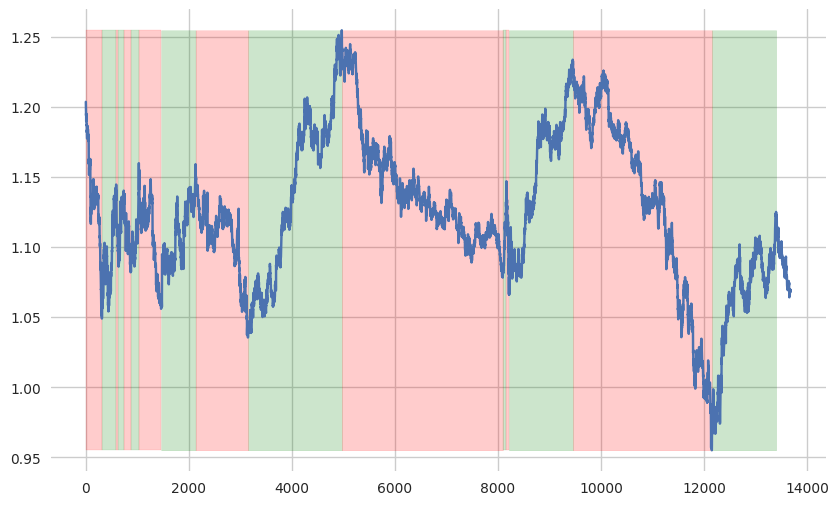

In [ ]:

df_c = eur_usd#.iloc[0:9_000].reset_index()

# Extract DC and Trend events
dc_events_up, dc_events_down, dc_events = calculate_dc(df_c, threshold=0.05)
trend_events_down, trend_events_up = calculate_future_trend(dc_events_down, dc_events_up, df_c)


min_price = df_c['close'].min()
max_price = df_c['close'].max()

plt.figure(figsize=(10, 6))
plt.plot(df_c['close'].iloc[0:,], label='Price')

# Add DC and OS events to the plot
for start, end in trend_events_up:
    plt.fill_between(df_c.index[start:end+1], min_price, max_price, alpha=0.2, color='green', label='DC Event')

for start, end in trend_events_down:
    plt.fill_between(df_c.index[start:end+1], min_price, max_price, alpha=0.2, color='red', label='DC Event')

plt.show()

### TARGET AND FEATURE-ENGINEERING

In [ ]:
#create targets

eur_usd = target_engineering(eur_usd, 0.05)
gbp_usd = target_engineering(gbp_usd, 0.05)
usd_cad = target_engineering(usd_cad, 0.05)
usd_chf = target_engineering(usd_chf, 0.05)
usd_jpy = target_engineering(usd_jpy, 0.05)




#create features
eur_usd = feature_engineering(eur_usd.iloc[:-1,:])
gbp_usd = feature_engineering(gbp_usd.iloc[:-1,:])
usd_cad = feature_engineering(usd_cad.iloc[:-1,:])
usd_chf = feature_engineering(usd_chf.iloc[:-1,:])
usd_jpy = feature_engineering(usd_jpy.iloc[:-1,:])



/content/Directional_change.py:151: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy["future_market_regime"] = df_copy["future_market_regime"].fillna(method="ffill")
/content/Directional_change.py:151: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy["future_market_regime"] = df_copy["future_market_regime"].fillna(method="ffill")
/content/Directional_change.py:151: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy["future_market_regime"] = df_copy["future_market_regime"].fillna(method="ffill")
/content/Directional_change.py:151: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy["future_market_regime"] = df_copy["future

### TRAIN TEST SPLIT

With time series data, the sequence of values is important. So we do not distribute the dataset into training and test sets in random fashion, but we select an arbitrary split point in the ordered list of observations and create two new datasets.

In [ ]:
eurusd_train = eur_usd.iloc[:int(len(eur_usd) * 0.70),:]
eurusd_test = eur_usd.iloc[int(len(eur_usd) * 0.70):,:]

gbpusd_train = gbp_usd.iloc[:int(len(gbp_usd) * 0.70),:]
gbpusd_test = gbp_usd.iloc[int(len(gbp_usd) * 0.70):,:]

usdcad_train = usd_cad.iloc[:int(len(usd_cad) * 0.70),:]
usdcad_test = gbp_usd.iloc[int(len(usd_cad) * 0.70):,:]

usdchf_train = usd_chf.iloc[:int(len(usd_chf) * 0.70),:]
usdchf_test = gbp_usd.iloc[int(len(usd_chf) * 0.70):,:]

usdjpy_train = usd_jpy.iloc[:int(len(usd_jpy) * 0.70),:]
usdjpy_test = gbp_usd.iloc[int(len(usd_jpy) * 0.70):,:]

In [ ]:
eurusd_test.value_counts('future_market_regime')

future_market_regime
1.0    2578
0.0    1525
Name: count, dtype: int64

### CORRELATION

In [ ]:
def create_correlation_chart(list_df,asset_names=None, one_col=False, new_columns=None):

    """
    graphs a correlation matrix.

    Parameters:
    - list_df: a list containing Pandas DataFrames
    - asset_names: a list containing the names of the assets in the list_df
    - one_col: a boolean value to determine the variables to present on the x-axis
    - new_columns: a dictionary containing the new interaction variables as keys and their corresponding values

    Returns:
    - graphs a correlation matrix
    """

    correlations = []
    all_columns = list_df[0].columns
    drop = ['time', 'open', 'high', 'low', 'close', 'low_time',
       'high_time', 'future_market_regime']
    list_X = [col for col in all_columns if col not in drop]
    col_y = "future_market_regime"
    assets = list_df
    for asset in assets:
        df_copy = asset[list_X + [col_y]].dropna()

        # Create feature matrix X and target vector y
        X = df_copy[list_X].iloc[:-1,:]
        y = df_copy[col_y].iloc[1:]

        dfc = pd.concat((X,y), axis=1)

        if len(list_df) > 1:
            correlations.append(dfc.corr()["future_market_regime"])
        else:
            correlations.append(dfc.corr())

    correlation = pd.concat(correlations, axis=1)
    if one_col == True and new_columns != None and len(list_df) == 1:

        if type(new_columns) == dict:
            keys = list(new_columns.keys())
        else:
            keys = new_columns
        n = len(keys)
        # Split into roughly equal parts
        split_size = n // 14
        remainder = n % 14

        splits = {}
        start = 0

        # Create 14 splits
        for i in range(1, 15):
            end = start + split_size + (1 if i <= remainder else 0)
            splits[f'correlation_{i}'] = correlation[keys[start:end]]
            start = end

        # Plot each of the 14 splits
        for i in range(1, 15):
            plt.figure(figsize=(15, 5))
            plt.title(f'Correlation Matrix (Split {i})')
            heatmap = sns.heatmap(
                splits[f'correlation_{i}'].loc[[col_y]],  # Only future_market_regime row
                vmin=-1, vmax=1, annot=True, cmap='cubehelix',
                annot_kws={"size": 8, "color": "black", "weight": "bold"},
                fmt=".2f", square=False, linewidths=0.1, cbar_kws={"shrink": 0.5}
            )
            heatmap.xaxis.tick_top()
            plt.xticks(rotation=45, ha='left', rotation_mode='anchor', fontsize=10)
            plt.yticks([0], [col_y], rotation=0)
            plt.show()
    elif one_col == False and new_columns != None and len(list_df) == 1:
        if type(new_columns) == dict:
            keys = list(new_columns.keys())
        else:
            keys = new_columns
        correlation = correlation.loc[keys, keys]
        plt.figure(figsize=(15,15))
        plt.title('Correlation Matrix')
        heatmap = sns.heatmap(correlation, vmax=1,annot=True,cmap='cubehelix',annot_kws={"size": 8,"color": "black","weight": "bold"},
        fmt=".2f",  square=False, linewidths=0.1, cbar_kws={"shrink": 0.5},)
        heatmap.xaxis.tick_top()
        plt.xticks(rotation=45,ha='left',rotation_mode='anchor',fontsize=10)
    elif one_col == False and new_columns == None and len(list_df) >1:
        correlation.columns = asset_names
        correlation = correlation.transpose()
        del correlation["future_market_regime"]
        correlation = correlation.transpose()
        plt.figure(figsize=(20, 10))
        sns.heatmap(correlation, annot=True, fmt=".2f", cmap='viridis', linewidths=.5)
        plt.title("Correlation on the Train set with the features and the target", size=15)
        plt.show()
    else:
        plt.figure(figsize=(15,15))
        plt.title('Correlation Matrix')
        heatmap = sns.heatmap(correlation, vmax=1,annot=True,cmap='cubehelix',annot_kws={"size": 8,"color": "black","weight": "bold"},
        fmt=".2f",  square=False, linewidths=0.1, cbar_kws={"shrink": 0.5},)
        heatmap.xaxis.tick_top()
        plt.xticks(rotation=45,ha='left',rotation_mode='anchor',fontsize=10)

### SINGLE ASSET ANALYSIS AND MODELLING

In [ ]:
eurusd_train.describe()

open         high          low        close    tick_volume  \
count  9572.000000  9572.000000  9572.000000  9572.000000    9572.000000   
mean      1.132203     1.133855     1.130640     1.132221   20192.170288   
std       0.044339     0.044290     0.044356     0.044343   14228.338601   
min       1.035550     1.039120     1.032490     1.035560     454.000000   
25%       1.101915     1.103410     1.100570     1.101938    9933.750000   
50%       1.124930     1.126700     1.123270     1.124945   16884.500000   
75%       1.164590     1.166020     1.163037     1.164662   27401.000000   
max       1.254860     1.255560     1.252330     1.254850  182409.000000   

       future_market_regime   candle_way      filling    amplitude  \
count           9572.000000  9572.000000  9572.000000  9572.000000   
mean               0.547012     0.019223     0.441775     0.138247   
std                0.497811     0.999867     0.251448     0.161697   
min                0.000000    -1.000000     0.000000     0.000000   
25%                0.000000    -1.000000     0.230386     0.039567   
50%                1.000000     1.000000     0.439105     0.090216   
75%                1.000000     1.000000     0.645432     0.180051   
max                1.000000     1.000000     1.000000     3.205171   

            spread  ...  vol_close_to_close_90  vol_parkinson_30  \
count  9572.000000  ...            9482.000000       9542.000000   
mean      0.003215  ...               0.002009          0.002001   
std       0.002412  ...               0.000775          0.000777   
min       0.000280  ...               0.000726          0.000741   
25%       0.001670  ...               0.001514          0.001505   
50%       0.002610  ...               0.001781          0.001831   
75%       0.004000  ...               0.002284          0.002286   
max       0.042620  ...               0.004774          0.006113   

       vol_parkinson_60  vol_parkinson_90  vol_rogers_satchell_30  \
count       9512.000000       9482.000000             9542.000000   
mean           0.002020          0.002030                0.002018   
std            0.000729          0.000699                0.000749   
min            0.000828          0.000830                0.000745   
25%            0.001559          0.001593                0.001529   
50%            0.001826          0.001820                0.001856   
75%            0.002322          0.002342                0.002314   
max            0.004949          0.004514                0.006227   

       vol_rogers_satchell_60  vol_rogers_satchell_90  vol_yang_zhang_30  \
count             9512.000000             9482.000000        9542.000000   
mean                 0.002033                0.002040           0.002792   
std                  0.000706                0.000680           0.001156   
min                  0.000850                0.000873           0.000953   
25%                  0.001584                0.001609           0.002068   
50%                  0.001853                0.001865           0.002544   
75%                  0.002320                0.002340           0.003175   
max                  0.005074                0.004618           0.009493   

       vol_yang_zhang_60  vol_yang_zhang_90  
count        9512.000000        9482.000000  
mean            0.002826           0.002843  
std             0.001072           0.001024  
min             0.001100           0.001100  
25%             0.002165           0.002202  
50%             0.002538           0.002547  
75%             0.003224           0.003291  
max             0.007160           0.006322  

[8 rows x 53 columns]

#### CORRELATION CHECK BETWEEN VARIABLES

In [ ]:
all_col = eurusd_train.columns
drop = ['time', 'open', 'high', 'low', 'close', 'low_time',
       'high_time', 'future_market_regime']
list_X = [col for col in all_col if col not in drop]

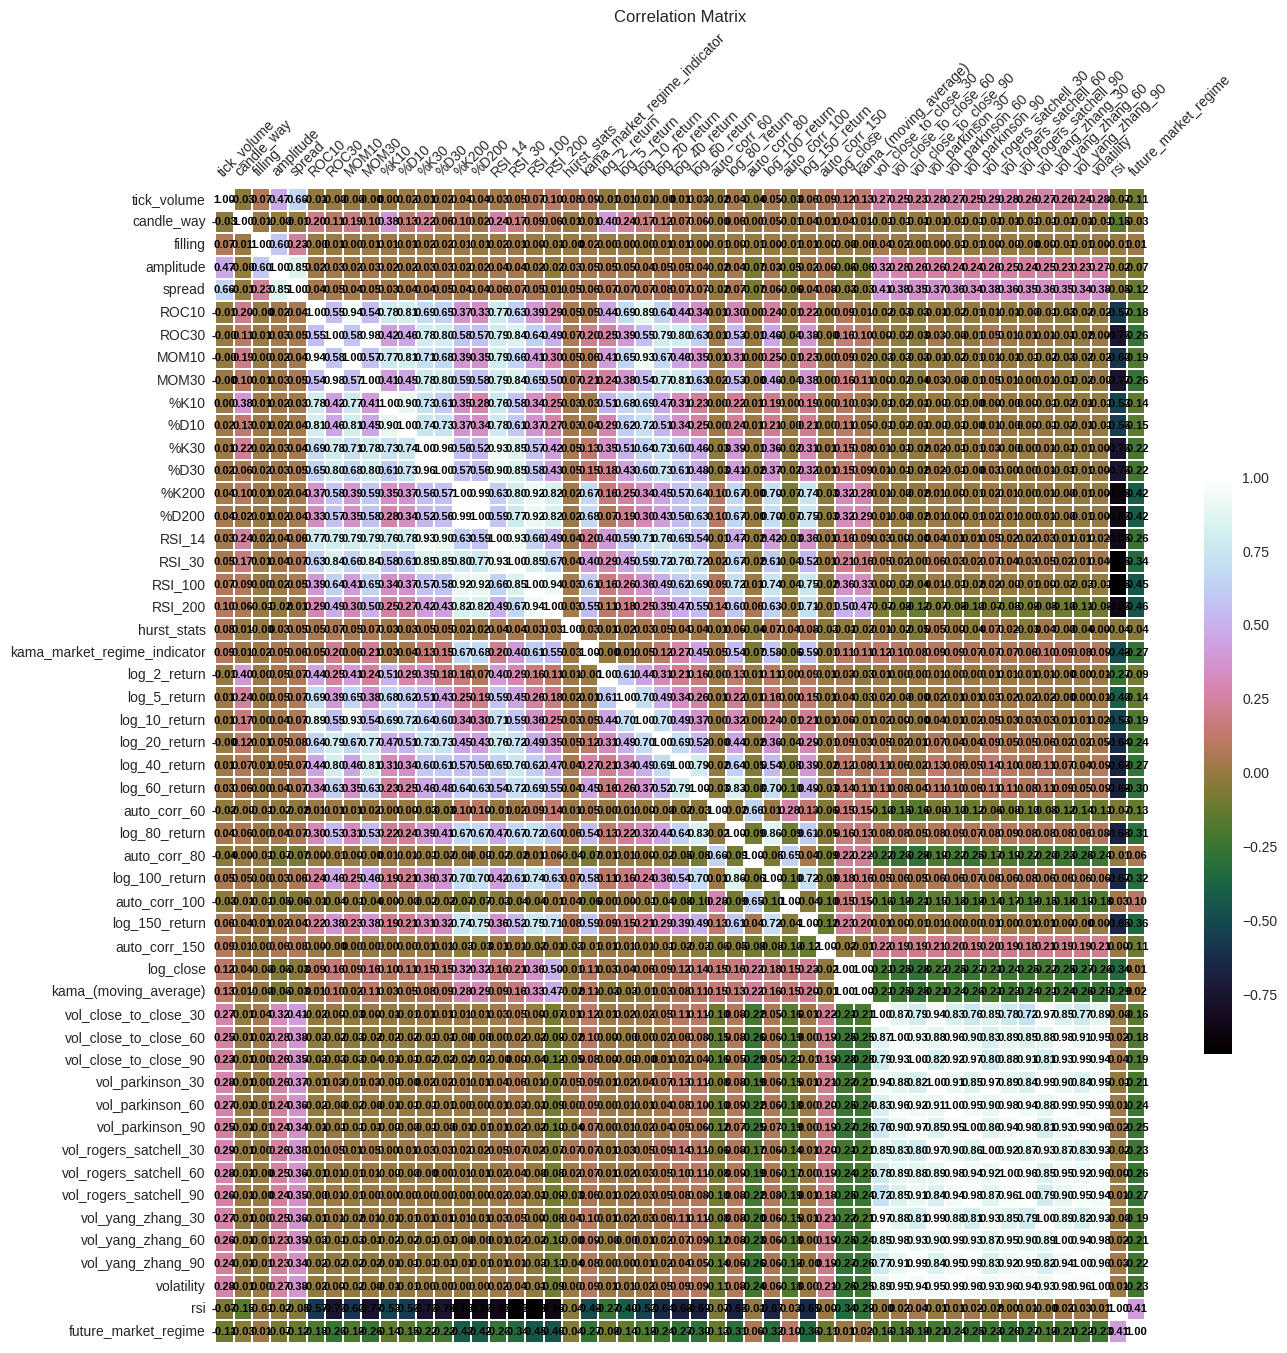

In [ ]:
create_correlation_chart([eurusd_train])

#### UNI-VARIABLE DISTRIBUTION

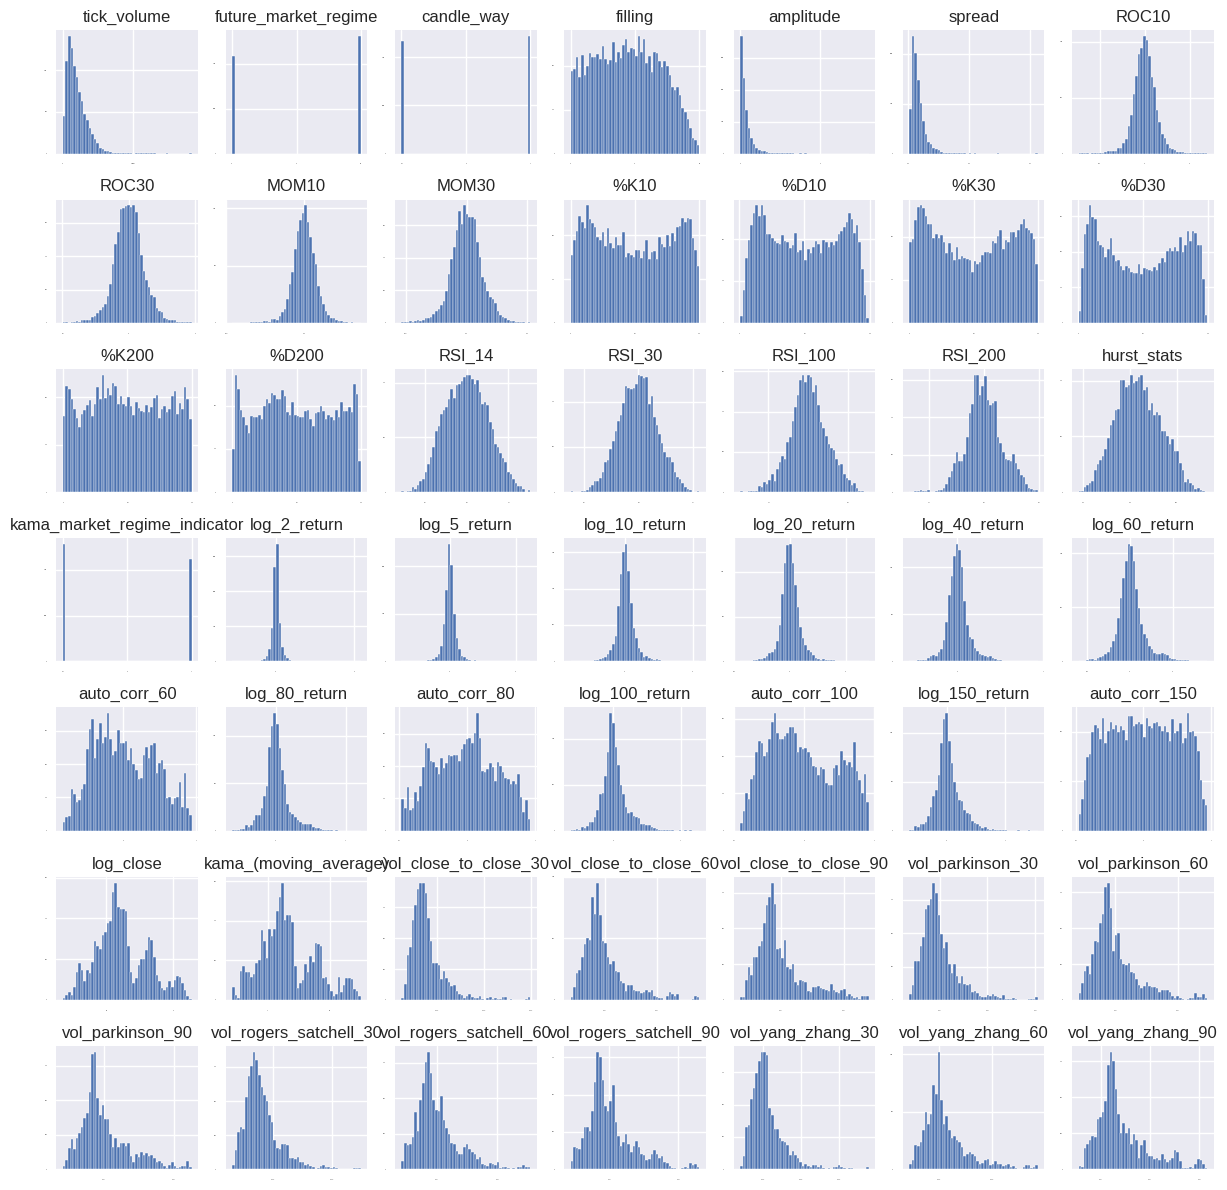

In [ ]:
#Distribution of Numeric variables
dataset = eurusd_train.drop(columns=['time', 'open', 'high', 'low', 'close'])

dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.tight_layout()
plt.show()

We have a mix of skewed, and stationary distributions. Next step is to use a box plot to see if truly some of these variables exhibit differences in their distribution by different regimes.

#### BOXPLOT OF PREDICTOR VARIABLES AGAINST RESPONSE VARIABLE AND T-TEST CHECK

In [ ]:
numerical_features = dataset.select_dtypes(include=['int64', 'float64']).columns.tolist()

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


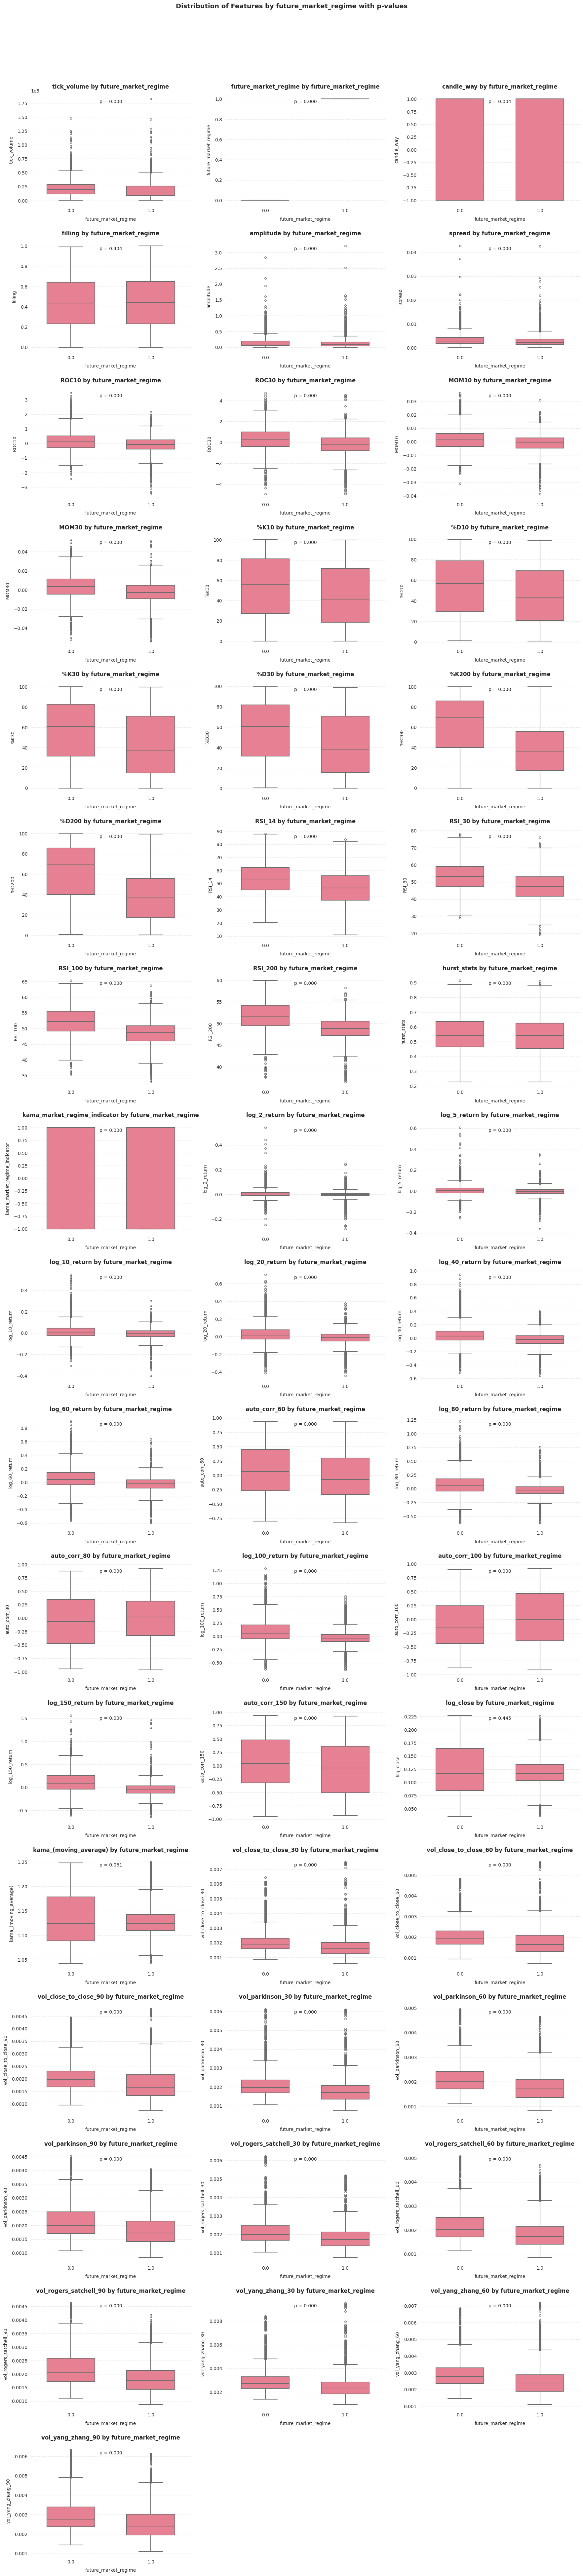

In [ ]:
# Set up the visualization style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

# Calculate subplot dimensions
num_features = len(numerical_features)
cols = min(3, num_features)
rows = (num_features + cols - 1) // cols

# Create figure
fig = plt.figure(figsize=(cols * 6, rows * 4.5))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Create box plots with p-value annotations
for i, feature in enumerate(numerical_features, 1):
    ax = plt.subplot(rows, cols, i)

    # Create boxplot
    sns.boxplot(x='future_market_regime', y=feature, data=eurusd_train,
                width=0.6, linewidth=1.5, fliersize=4)

    # Calculate p-value using a t-test
    uptrend_data = eurusd_train[feature][eurusd_train['future_market_regime'] == 1.0].dropna()
    downtrend_data = eurusd_train[feature][eurusd_train['future_market_regime'] == 0.0].dropna()

    if len(uptrend_data) > 1 and len(downtrend_data) > 1:
        test_res = stats.ttest_ind(uptrend_data, downtrend_data)
        p_value = test_res.pvalue
        # Format p-value string
        p_text = f"p = {p_value:.3f}"

        # Add p-value annotation to the plot
        ax.text(0.5, 0.95, p_text, transform=ax.transAxes,
                ha='center', va='top', fontsize=10,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=3))

    # Formatting
    ax.set_title(f'{feature} by future_market_regime',
                 fontsize=12, pad=12, fontweight='semibold')
    ax.set_xlabel('future_market_regime', fontsize=10, labelpad=8)
    ax.set_ylabel(feature, fontsize=10, labelpad=8)

    if max([len(str(x)) for x in eurusd_train['future_market_regime'].unique()]) > 5:
        plt.xticks(rotation=45, ha='right')

    ax.yaxis.grid(True, linestyle='--', alpha=0.4)
    sns.despine()

    if eurusd_train[feature].max() > 1000:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# Add overall title
plt.suptitle(f'Distribution of Features by future_market_regime with p-values',
             y=1.02, fontsize=14, fontweight='bold')
plt.tight_layout(pad=2.0)
plt.show()

### Hypothesis Testing on predictor variables

we are interested in identifying whether there is a statistically significant difference between lagged log returns during uptrend and downtrend. Therefore, our null hypothesis is that the mean of lagged log returns during uptrend is the same as the mean of uptrend during the downtrend. In other words:


H_0 : average lagged log returns during uptrend - average lagged log returns during downtrend = 0

and

H_a : average lagged log returns during uptrend - average lagged log returns during downtrend ≠ 0



The p-values from t-tests conducted on the mean differences of each variables against the response variable categories produces values less than 0.0001 (for some), which is far below the standard critical 0.05 value, while a few are greater than 0.05. As a conclusion, we can reject the null hypothesis and confirm that these variables are predictive (if p-value < 0.05): that is, there is a statistically significant difference between mean value in an uptrend and downtrend. And accept the null hypothesis for variables showing p-values > 0.05.

Hence, all variables apart from filling, kama (moving average), and log_close price are predictable. This is only a subset of the data, so we an still leave these variables in and test the performance of the model with or without them.

#### MOSAIC PLOTS OF SOMEWHAT CATEGORICAL VARIABLES; CANDLE WAY & KAMA MARKET REGIME

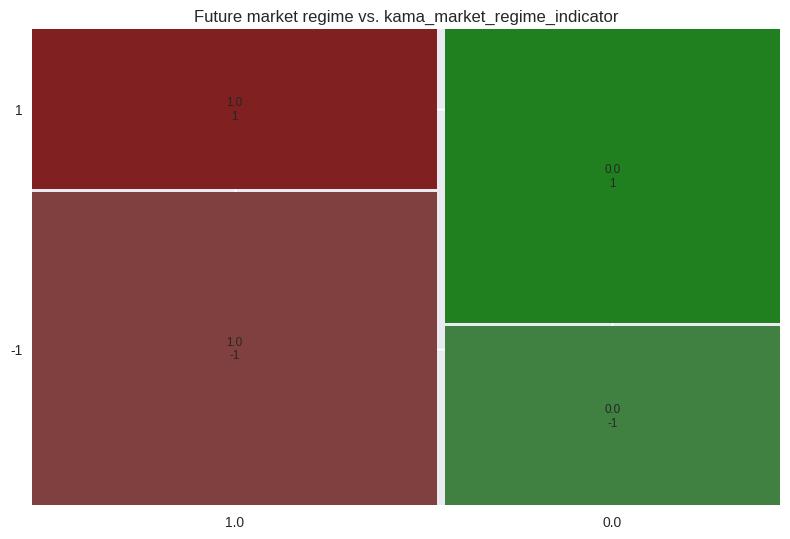

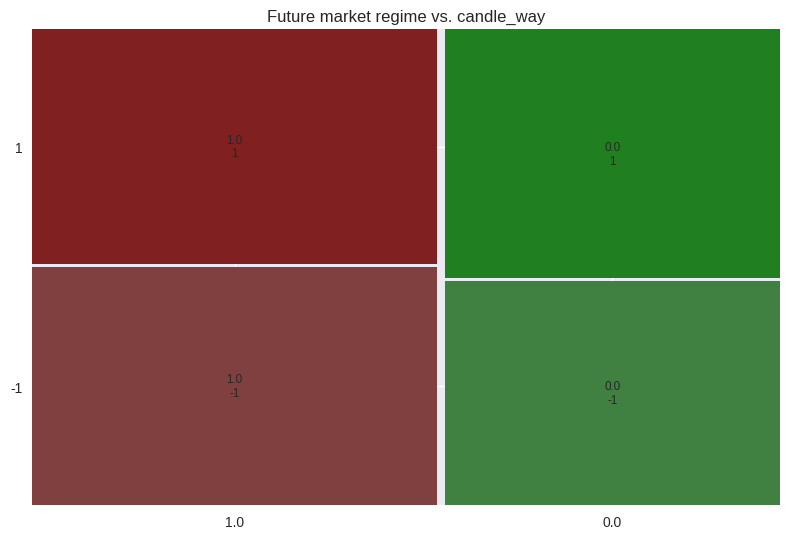

In [ ]:
for i in ['kama_market_regime_indicator', 'candle_way']:
    fig, ax_dict = mosaic(
        eurusd_train,
        ['future_market_regime', i],
        title=f"Future market regime vs. {i}",
        gap=0.01  # Adjust gap between subplots if needed
    )

    plt.tight_layout()
    plt.show()

Somewhat categorical vaariables like kama market regime, and candle way are plotted using the mosaic plots to understand their distribution across the response variable categories. And as indicated in the correlation matrix plot, the mosaic plots indicates an association between the kama market regime indicator and the future market regime, while the opposite holds true for candle way and the response variable.

In [ ]:
# import scipy.stats as stats

# for col in numerical_features:

#     #segment the both regimes
#     uptrend_data = eurusd_train[col][eurusd_train['future_market_regime'] == 1.0]
#     downtrend_data = eurusd_train[col][eurusd_train['future_market_regime'] == 0.0]  # Fixed ]

#     #Drop NA values
#     uptrend_data = uptrend_data.dropna()
#     downtrend_data = downtrend_data.dropna()

#     #Verify we have data
#     print(f"Uptrend samples: {len(uptrend_data)}, Downtrend samples: {len(downtrend_data)}")

#     #apply test statistic
#     if len(uptrend_data) > 1 and len(downtrend_data) > 1:  # Need at least 2 samples per group
#         test_res = stats.ttest_ind(uptrend_data, downtrend_data)
#         print(f"Statistic value {col}: {test_res.statistic:.03f}, p-value: {test_res.pvalue:.03f}")
#         print()
#     else:
#         print("Insufficient data for t-test")

#### FURTHER FEATURE ENGINEERING

#### Categorise, Standardize & Apply Kernel PCA for the RSI and volatility variables

In [ ]:
eurusd_train.copy().dropna(inplace=True)

rsi_features = ['RSI_14', 'RSI_30', 'RSI_100', 'RSI_200']
volatility_features = ['vol_close_to_close_30', 'vol_close_to_close_60', 'vol_close_to_close_90',
                       'vol_parkinson_30','vol_parkinson_60',
                       'vol_parkinson_90', 'vol_rogers_satchell_30', 'vol_rogers_satchell_60', 'vol_rogers_satchell_90',
                       'vol_yang_zhang_30', 'vol_yang_zhang_60', 'vol_yang_zhang_90']

scaler_vol = StandardScaler() #volatility
scaled_vol_train =scaler_vol.fit_transform(eurusd_train[volatility_features])  # Fit only on training set
scaled_vol_test =scaler_vol.transform(eurusd_test[volatility_features])  # transform test set

scaler_rsi = StandardScaler() #rsi
scaler_rsi_train = scaler_rsi.fit_transform(eurusd_train[rsi_features])  # Fit only on training set
scaler_rsi_test = scaler_rsi.transform(eurusd_test[rsi_features])  # transform test set


In [ ]:
# Apply Kernel PCA
pca_vol = KernelPCA(n_components=1) #volatility
eurusd_train.loc[:,'volatility'] = pca_vol.fit_transform(scaled_vol_train)  # Fit on train set
eurusd_test.loc[:,'volatility'] = pca_vol.transform(scaled_vol_test)

pca_rsi = KernelPCA(n_components=1) #rsi
eurusd_train.loc[:,'rsi'] = pca_rsi.fit_transform(scaler_rsi_train)  # Fit on train set
eurusd_test.loc[:,'rsi'] = pca_rsi.transform(scaler_rsi_test)



### VIEW PCA GENERATED VOLATILITY AGAINST OTHERS

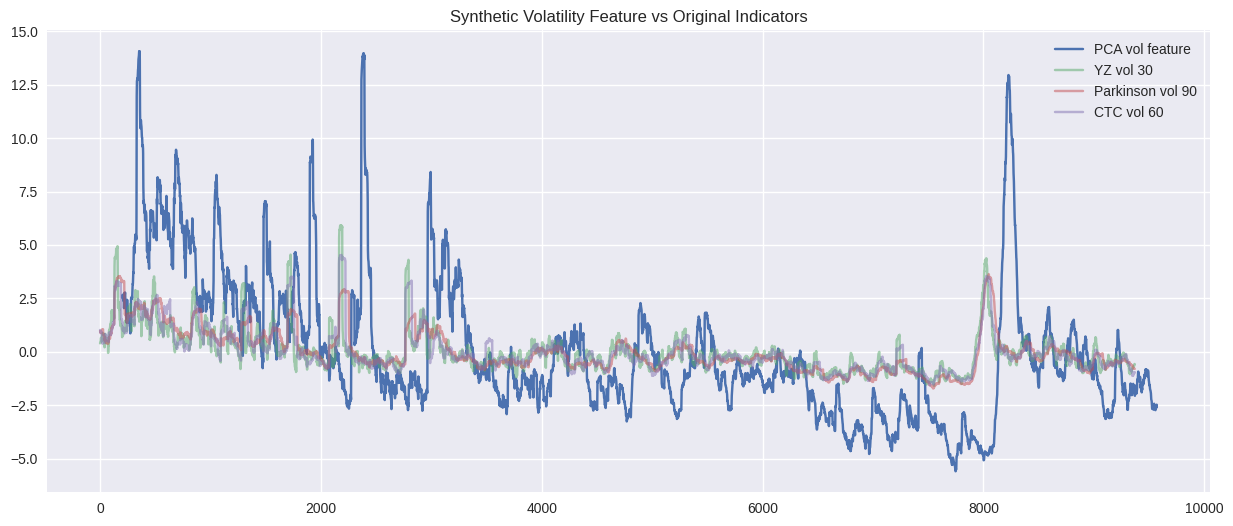

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
plt.figure(figsize=(15, 6))

plt.plot(eurusd_train["volatility"], label="PCA vol feature")
plt.plot(scaled_vol_train[:, volatility_features.index("vol_yang_zhang_30")], label="YZ vol 30", alpha=0.5)
plt.plot(scaled_vol_train[:, volatility_features.index("vol_parkinson_90")], label="Parkinson vol 90", alpha=0.5)
plt.plot(scaled_vol_train[:, volatility_features.index("vol_close_to_close_60")], label="CTC vol 60", alpha=0.5)

plt.legend()
plt.title("Synthetic Volatility Feature vs Original Indicators")
plt.show()

### VIEW PCA GENERATED RSI AGAINST OTHERS

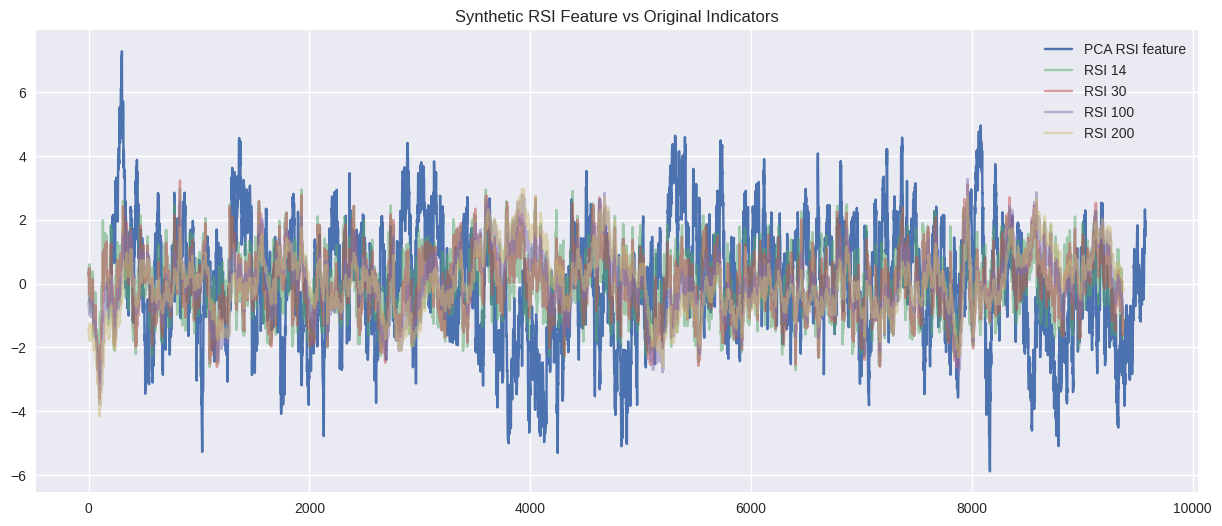

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
plt.figure(figsize=(15, 6))

plt.plot(eurusd_train["rsi"], label="PCA RSI feature")
plt.plot(scaler_rsi_train[:, rsi_features.index("RSI_14")], label="RSI 14", alpha=0.5)
plt.plot(scaler_rsi_train[:, rsi_features.index("RSI_30")], label="RSI 30", alpha=0.5)
plt.plot(scaler_rsi_train[:, rsi_features.index("RSI_100")], label="RSI 100", alpha=0.5)
plt.plot(scaler_rsi_train[:, rsi_features.index("RSI_200")], label="RSI 200", alpha=0.5)

plt.legend()
plt.title("Synthetic RSI Feature vs Original Indicators")
plt.show()

#### VIEW OF ADJUSTED PREDICTOR VARIABLES CORRELATION

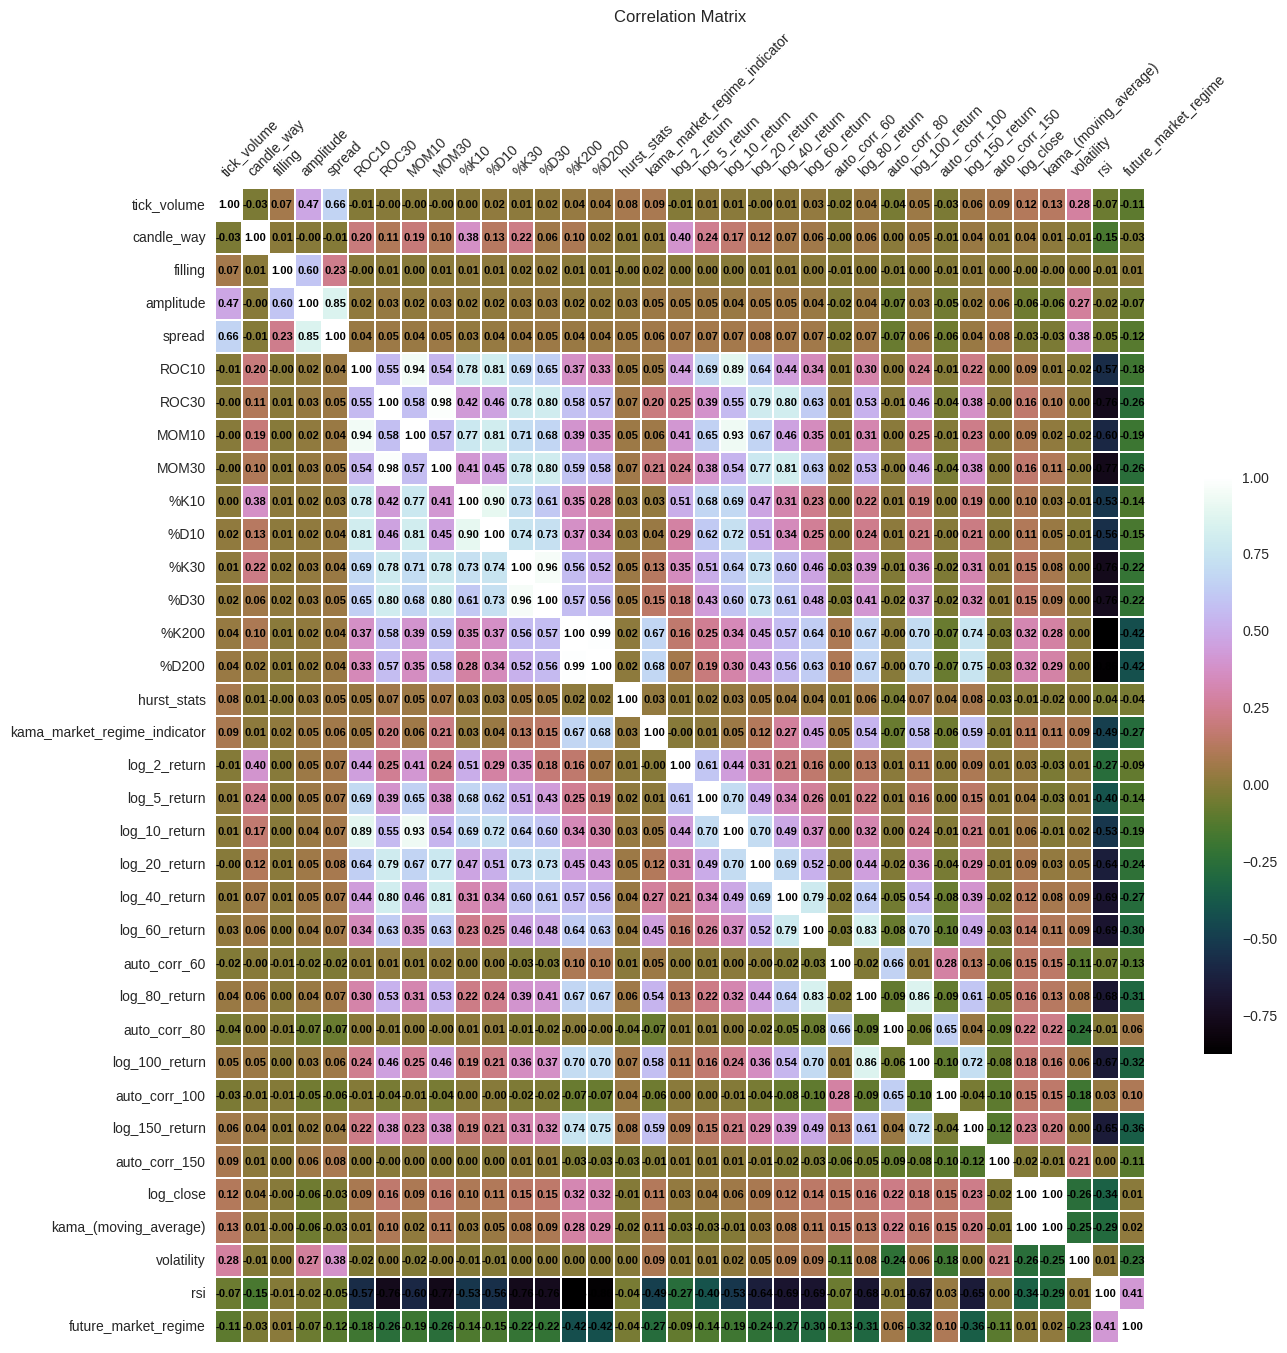

In [ ]:
new_data = eurusd_train.drop(columns=rsi_features + volatility_features)
create_correlation_chart([new_data])

After the application of the PCA to the collective volatility and RSI variables, we have derived a single volatility and RSI indicator.

### MODEL BUILDING OF A SINGLE ASSET

In [ ]:

# Make a copy of the dataframe and drop rows with NA values
drop_cols = ['time', 'open', 'high', 'low', 'close', 'low_time',
       'high_time']
variables = [col for col in new_data.columns if col not in drop_cols]

df_copy = new_data[variables].copy().dropna()
numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
df_copy = df_copy[~np.isinf(df_copy[numeric_cols]).any(axis=1)]
#f_copy = df_copy[~np.isinf(df_copy).any(axis=1)]

# Create feature matrix X and target vector y
X = df_copy.drop(columns=['future_market_regime']).iloc[:-1,:].values
y = df_copy['future_market_regime'].iloc[1:].values

# Split the dataset into training and testing sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, shuffle=False)


# Create and train a RandomForest model
model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = model.predict(X_validation)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_validation, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calcul de l'accuracy
acc = accuracy_score(y_validation, y_pred)
print(f"\nAccuracy: {acc:.4f}")

# Calcul du score F1
f1 = f1_score(y_validation, y_pred, pos_label=1.0)
print(f"F1 Score: {f1:.4f}")

Confusion Matrix:
[[1021  292]
 [ 123  438]]

Accuracy: 0.7785
F1 Score: 0.6785


### ROBUSTNESS TEST USING CROSS VALIDATION TEST

### TEST OPTIONS AND EVALUATION METRICS

In [ ]:
# test options for classification
num_folds = 10
#scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'
scoring = 'f1'

### COMPARE MODELS AND ALGORITHMS

In [ ]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))

#Ensable Models
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

### K-FOLD CROSS VALIDATION (RESAMPLING)

In [ ]:
# Make a copy of the dataframe and drop rows with NA values
drop_cols = ['time', 'open', 'high', 'low', 'close', 'low_time',
       'high_time']
variables = [col for col in new_data.columns if col not in drop_cols]

df_copy = new_data[variables].copy().dropna()
numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
df_copy = df_copy[~np.isinf(df_copy[numeric_cols]).any(axis=1)]
#f_copy = df_copy[~np.isinf(df_copy).any(axis=1)]

# Create feature matrix X and target vector y
X_train = df_copy.drop(columns=['future_market_regime']).iloc[:-1,:].values
y_train = df_copy['future_market_regime'].iloc[1:].values

names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    #kfold = KFold(n_splits=num_folds)
    tscv = TimeSeriesSplit(n_splits=num_folds)
    #converted mean squared error to positive. Thelower the better
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring=scoring)
    kfold_results.append(cv_results)

    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.536545 (0.259354)
LDA: 0.629736 (0.257933)
KNN: 0.494119 (0.216293)
CART: 0.541668 (0.309386)
AB: 0.579889 (0.304636)
RF: 0.579914 (0.303787)


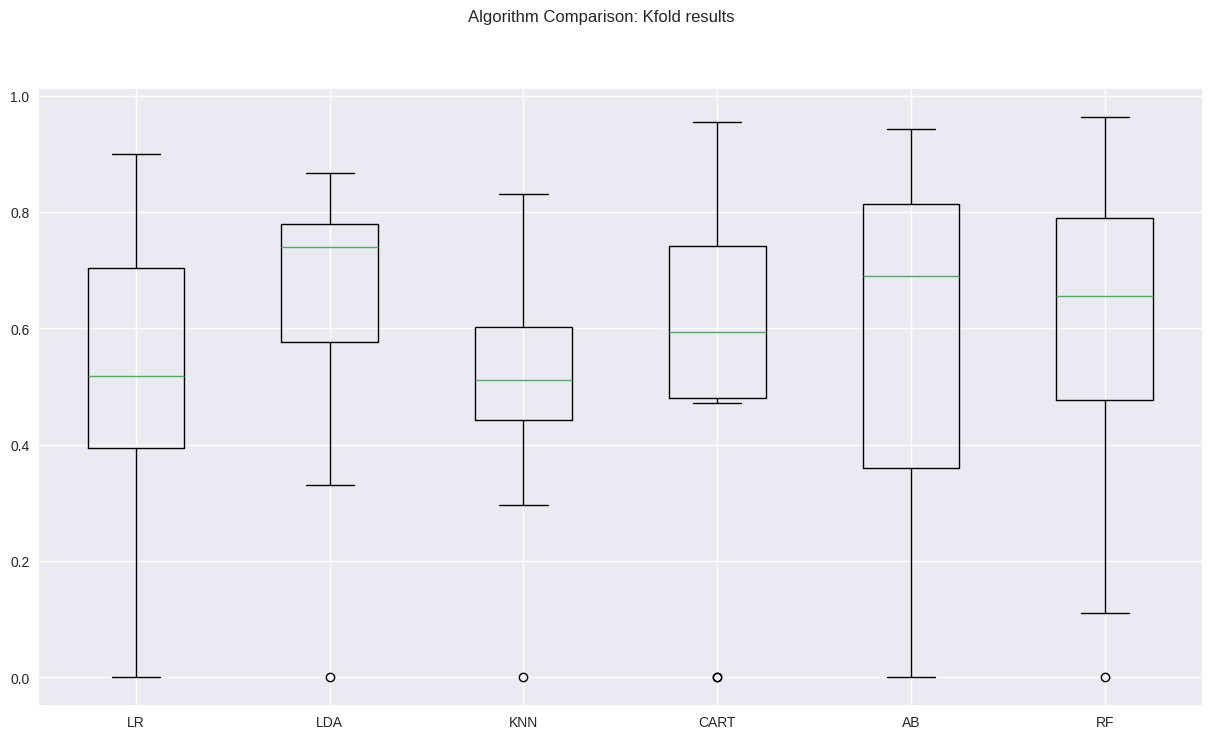

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

Although the results of a couple of the models dontlook so good, we can run some model tuning on both Adaboost and Random forest classifiers.

### MODEL TUNING AND GRID SEARCH


#### ADABOOST

In [ ]:
# Define the parameter grid for AdaBoost
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [50, 100]  # Typical range for AdaBoost
learning_rate = [0.1, 0.5, 1.0]  # Common learning rates to try

param_grid = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate
}
model = AdaBoostClassifier() # Create the AdaBoost model
tscv = TimeSeriesSplit(n_splits=num_folds) # Set up KFold cross-validation
grid = GridSearchCV(estimator=model,param_grid=param_grid,scoring=scoring,cv=tscv) # Configure GridSearchCV
grid_result = grid.fit(X_train, y_train) # Fit the grid search
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # Print the best results

Best: 0.645360 using {'learning_rate': 0.1, 'n_estimators': 50}


In [ ]:
#scaler = StandardScaler().fit(X_train)
#rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
tscv = TimeSeriesSplit(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=tscv)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.654499 using {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}


### LINEAR REGRESSION

In [ ]:
new_data.columns

Index(['time', 'open', 'high', 'low', 'close', 'tick_volume', 'low_time',
       'high_time', 'future_market_regime', 'candle_way', 'filling',
       'amplitude', 'spread', 'ROC10', 'ROC30', 'MOM10', 'MOM30', '%K10',
       '%D10', '%K30', '%D30', '%K200', '%D200', 'hurst_stats',
       'kama_market_regime_indicator', 'log_2_return', 'log_5_return',
       'log_10_return', 'log_20_return', 'log_40_return', 'log_60_return',
       'auto_corr_60', 'log_80_return', 'auto_corr_80', 'log_100_return',
       'auto_corr_100', 'log_150_return', 'auto_corr_150', 'log_close',
       'kama_(moving_average)', 'volatility', 'rsi'],
      dtype='object')

# CROSS VALIDATION

### UNSEEN TEST DATA CHECK

### TRAIN ALL DATA AND PREDICT WITH UNSEEN TEST SET

In [ ]:
eurusd_test_new =  eurusd_test.drop(columns=rsi_features + volatility_features)
eurusd_test_new.columns

Index(['time', 'open', 'high', 'low', 'close', 'tick_volume', 'low_time',
       'high_time', 'future_market_regime', 'candle_way', 'filling',
       'amplitude', 'spread', 'ROC10', 'ROC30', 'MOM10', 'MOM30', '%K10',
       '%D10', '%K30', '%D30', '%K200', '%D200', 'hurst_stats',
       'kama_market_regime_indicator', 'log_2_return', 'log_5_return',
       'log_10_return', 'log_20_return', 'log_40_return', 'log_60_return',
       'auto_corr_60', 'log_80_return', 'auto_corr_80', 'log_100_return',
       'auto_corr_100', 'log_150_return', 'auto_corr_150', 'log_close',
       'kama_(moving_average)', 'volatility', 'rsi'],
      dtype='object')

In [ ]:
drop_cols = ['time', 'open', 'high', 'low', 'close', 'low_time',
       'high_time']
variables = [col for col in new_data.columns if col not in drop_cols]

df_copy = eurusd_test_new[variables].copy().dropna()
numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
df_copy = df_copy[~np.isinf(df_copy[numeric_cols]).any(axis=1)]
#f_copy = df_copy[~np.isinf(df_copy).any(axis=1)]

# Create feature matrix X and target vector y
X_test = df_copy.drop(columns=['future_market_regime']).iloc[:-1,:].values
y_test = df_copy['future_market_regime'].iloc[1:].values


# Create and train a RandomForest model
model = RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=20, random_state=42)

model.fit(X_train, y_train)
predictions = model.predict(X_test)
#print(accuracy_score(y_validation, predictions))
print(f1_score(y_test, predictions))

0.7581786030061892


In [ ]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Calcul de l'accuracy
acc = accuracy_score(y_test, predictions)
print(f"\nAccuracy: {acc:.4f}")

# Calcul du score F1
f1 = f1_score(y_test, predictions, pos_label=1.0)
print(f"F1 Score: {f1:.4f}")

Confusion Matrix:
[[1293  232]
 [ 862 1715]]

Accuracy: 0.7333
F1 Score: 0.7582


### FEATURE IMPORTANCE CHECK

Text(0.5, 0, 'Variable Importance')

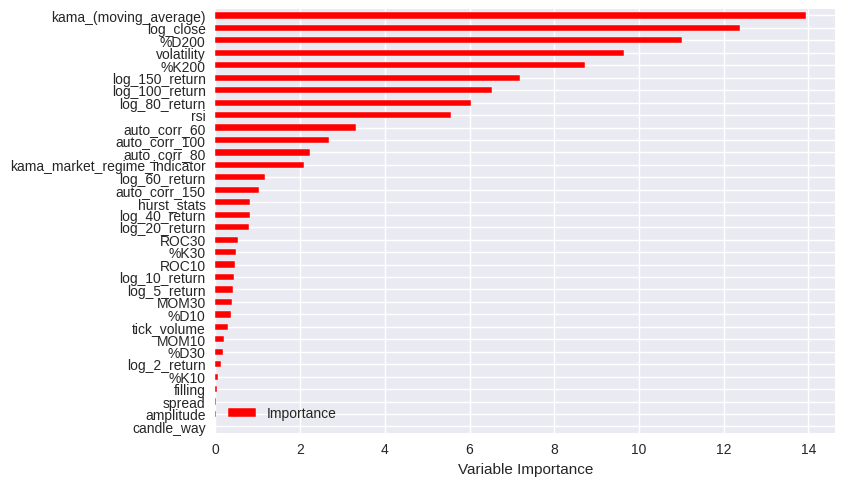

In [ ]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=df_copy.drop(columns=['future_market_regime']).columns)
Importance.sort_values('Importance', axis=0,ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

### MODEL BUILDING FOR ALL ASSETS COMBINED

In [ ]:
def data_edits(list_df):
    train_list = []
    test_list = []

    for train, test in list_df.copy():
        train=train.copy()
        test=test.copy()
        train.dropna(inplace=True)

        rsi_features = ['RSI_14', 'RSI_30', 'RSI_100', 'RSI_200']
        volatility_features = ['vol_close_to_close_30', 'vol_close_to_close_60', 'vol_close_to_close_90',
                            'vol_parkinson_30','vol_parkinson_60',
                            'vol_parkinson_90', 'vol_rogers_satchell_30', 'vol_rogers_satchell_60', 'vol_rogers_satchell_90',
                            'vol_yang_zhang_30', 'vol_yang_zhang_60', 'vol_yang_zhang_90']

        scaler_vol = StandardScaler() #volatility
        scaled_vol_train =scaler_vol.fit_transform(train[volatility_features])  # Fit only on training set
        scaled_vol_test =scaler_vol.transform(test[volatility_features])  # transform test set

        scaler_rsi = StandardScaler() #rsi
        scaler_rsi_train = scaler_rsi.fit_transform(train[rsi_features])  # Fit only on training set
        scaler_rsi_test = scaler_rsi.transform(test[rsi_features])  # transform test set

        # Apply Kernel PCA
        pca_vol = KernelPCA(n_components=1) #volatility
        train.loc[:,'volatility'] = pca_vol.fit_transform(scaled_vol_train)  # Fit on train set
        test.loc[:,'volatility'] = pca_vol.transform(scaled_vol_test)

        pca_rsi = KernelPCA(n_components=1) #rsi
        train.loc[:,'rsi'] = pca_rsi.fit_transform(scaler_rsi_train)  # Fit on train set
        test.loc[:,'rsi'] = pca_rsi.transform(scaler_rsi_test)

        new_train = train.drop(columns=rsi_features + volatility_features)
        new_test = test.drop(columns=rsi_features + volatility_features)

        train_list.append(new_train)
        test_list.append(new_test)
    train_df = pd.concat(train_list)
    test_df = pd.concat(test_list)

    return train_list, train_df, test_df


In [ ]:
train_list, combined_train, combined_test = data_edits([(eurusd_train,eurusd_test), (gbpusd_train,gbpusd_test), (usdjpy_train,usdjpy_test)])


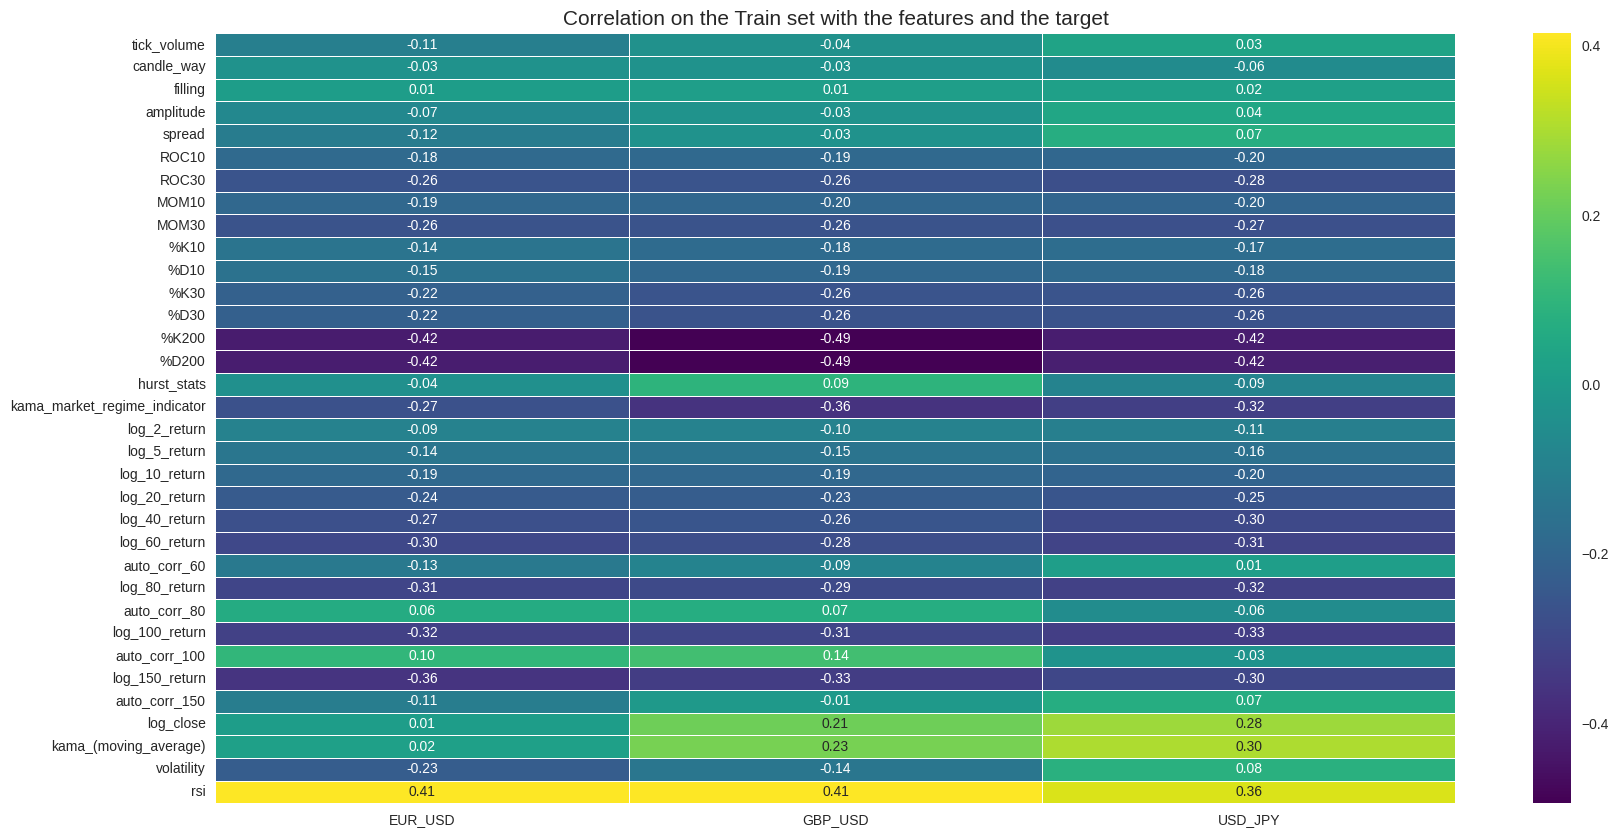

In [ ]:
create_correlation_chart(train_list, asset_names=['EUR_USD', 'GBP_USD','USD_JPY'])

The log close and kama_(moving_average) predictors dont seem to have much predictive power on the EUR_USD data, but possesses stronger correlation on the GBP_USD and the USD_JPY set.

In [ ]:
combined_train.columns

Index(['time', 'open', 'high', 'low', 'close', 'tick_volume', 'low_time',
       'high_time', 'future_market_regime', 'candle_way', 'filling',
       'amplitude', 'spread', 'ROC10', 'ROC30', 'MOM10', 'MOM30', '%K10',
       '%D10', '%K30', '%D30', '%K200', '%D200', 'hurst_stats',
       'kama_market_regime_indicator', 'log_2_return', 'log_5_return',
       'log_10_return', 'log_20_return', 'log_40_return', 'log_60_return',
       'auto_corr_60', 'log_80_return', 'auto_corr_80', 'log_100_return',
       'auto_corr_100', 'log_150_return', 'auto_corr_150', 'log_close',
       'kama_(moving_average)', 'volatility', 'rsi'],
      dtype='object')

In [ ]:
# Make a copy of the dataframe and drop rows with NA values

drop_cols = ['time', 'open', 'high', 'low', 'close', 'low_time',
       'high_time']
variables = [col for col in new_data.columns if col not in drop_cols]

df_copy = combined_train[variables].copy().dropna()
numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
df_copy = df_copy[~np.isinf(df_copy[numeric_cols]).any(axis=1)]


# Create feature matrix X and target vector y
X = df_copy.drop(columns=['future_market_regime']).iloc[:-1,:].values
y = df_copy['future_market_regime'].iloc[1:].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Create and train a RandomForest model
model = RandomForestClassifier(max_depth=3,random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, random_state=42)

In [ ]:
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calcul de l'accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc:.4f}")

# Calcul du score F1
f1 = f1_score(y_test, y_pred, pos_label=1.0)
print(f"F1 Score: {f1:.4f}")

Confusion Matrix:
[[ 125 2477]
 [  59 2962]]

Accuracy: 0.5490
F1 Score: 0.7002


### CROSSVALIDATION ACROSS SEVERAL MODELS

In [ ]:
drop_cols = ['time', 'open', 'high', 'low', 'close', 'low_time',
       'high_time']
variables = [col for col in new_data.columns if col not in drop_cols]

df_copy = combined_train[variables].copy().dropna()
numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
df_copy = df_copy[~np.isinf(df_copy[numeric_cols]).any(axis=1)]

# Create feature matrix X and target vector y
X_train = df_copy.drop(columns=['future_market_regime']).iloc[:-1,:].values
y_train = df_copy['future_market_regime'].iloc[1:].values

names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    #kfold = KFold(n_splits=num_folds)
    tscv = TimeSeriesSplit(n_splits=num_folds)
    #converted mean squared error to positive. Thelower the better
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring=scoring)
    kfold_results.append(cv_results)

    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.686052 (0.129803)
LDA: 0.668058 (0.165594)
KNN: 0.595728 (0.077027)
CART: 0.639497 (0.086373)
AB: 0.694188 (0.101869)
RF: 0.689831 (0.114757)


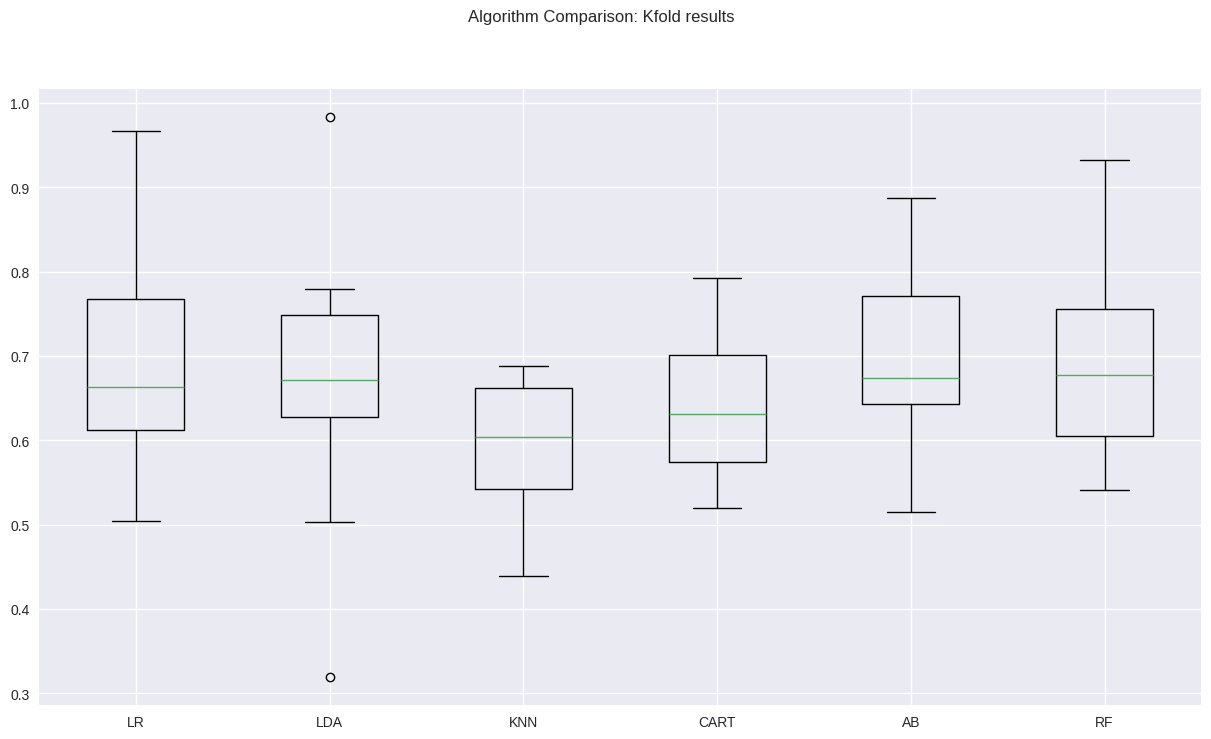

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

### MODEL TUNING OF THE RANDOM FOREST MODEL

In [ ]:
#scaler = StandardScaler().fit(X_train)
#rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
tscv = TimeSeriesSplit(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=tscv)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.727547 using {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}


### RETRAIN MODEL WITH TUNED MODEL PARAMETERS AND TEST WITH UNSEEN TEST SET

In [ ]:
drop_cols = ['time', 'open', 'high', 'low', 'close', 'low_time',
       'high_time']
variables = [col for col in new_data.columns if col not in drop_cols]

df_copy = combined_test[variables].copy().dropna()
numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
df_copy = df_copy[~np.isinf(df_copy[numeric_cols]).any(axis=1)]

# Create feature matrix X and target vector y
X_test = df_copy.drop(columns=['future_market_regime']).iloc[:-1,:].values
y_test = df_copy['future_market_regime'].iloc[1:].values


# Create and train a RandomForest model
model = RandomForestClassifier(criterion='gini', max_depth=5, n_estimators=80, random_state=42)

model.fit(X_train, y_train)
predictions = model.predict(X_test)
#print(accuracy_score(y_validation, predictions))
print(f1_score(y_test, predictions))

0.7209913631242959


### FEATURE IMPORTANCE WITH TRAINED MODEL

Text(0.5, 0, 'Variable Importance')

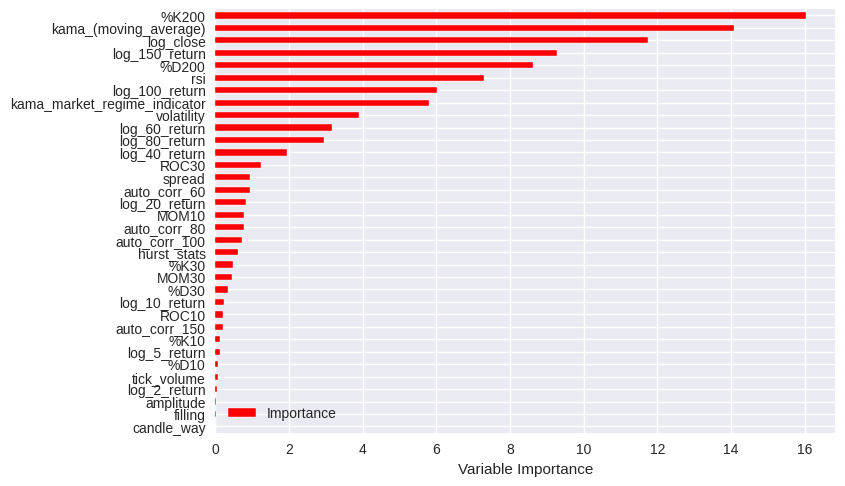

In [ ]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=df_copy.drop(columns=['future_market_regime']).columns)
Importance.sort_values('Importance', axis=0,ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')